# SARIMAX

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/processed.csv')

# Parse dates if necessary and ensure the 'Date' column is of the datetime type
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [ ]:
# Check for any missing values in the dataset
missing_values = data.isnull().sum()

# Show the result of missing values check and the first few rows to verify the changes
missing_values_summary = missing_values[missing_values > 0]
data_head = data.head()

#missing_values_summary, data_head


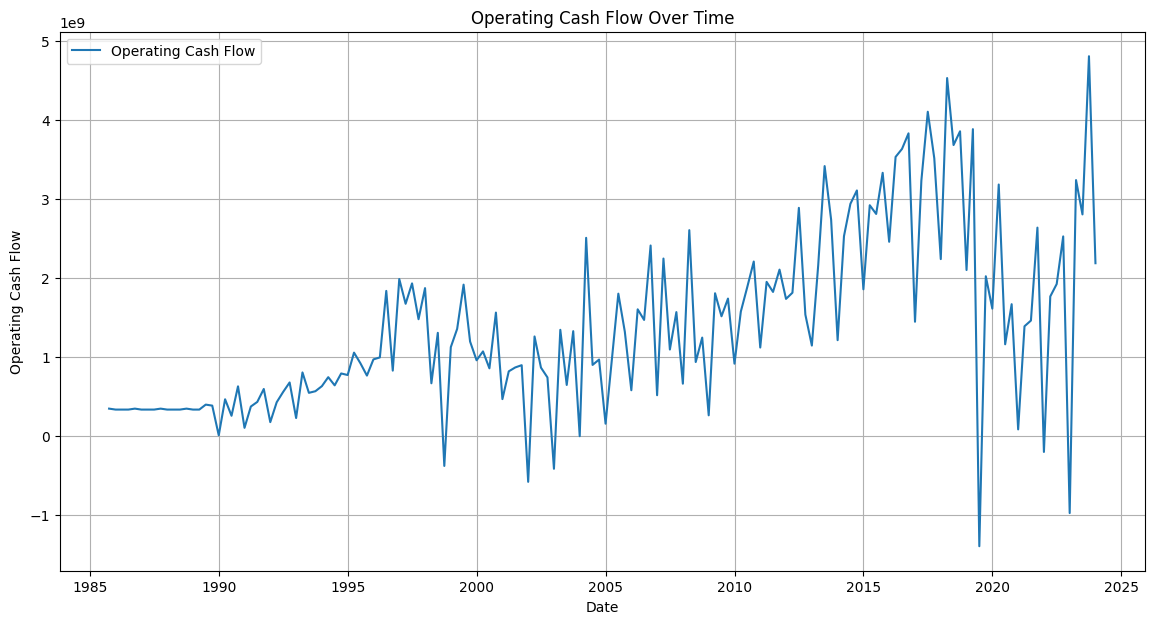

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the column name for Operating Cash Flow based on typical financial reporting terms
# (Assuming it is labeled clearly, we will look for a likely match. Adjust the name as needed.)
operating_cash_flow_col = 'OperatingCashFlow'  # Change if different

# Plot Operating Cash Flow
plt.figure(figsize=(14, 7))
plt.plot(data.index, data[operating_cash_flow_col], label='Operating Cash Flow')
plt.title('Operating Cash Flow Over Time')
plt.xlabel('Date')
plt.ylabel('Operating Cash Flow')
plt.legend()
plt.grid(True)
plt.show()

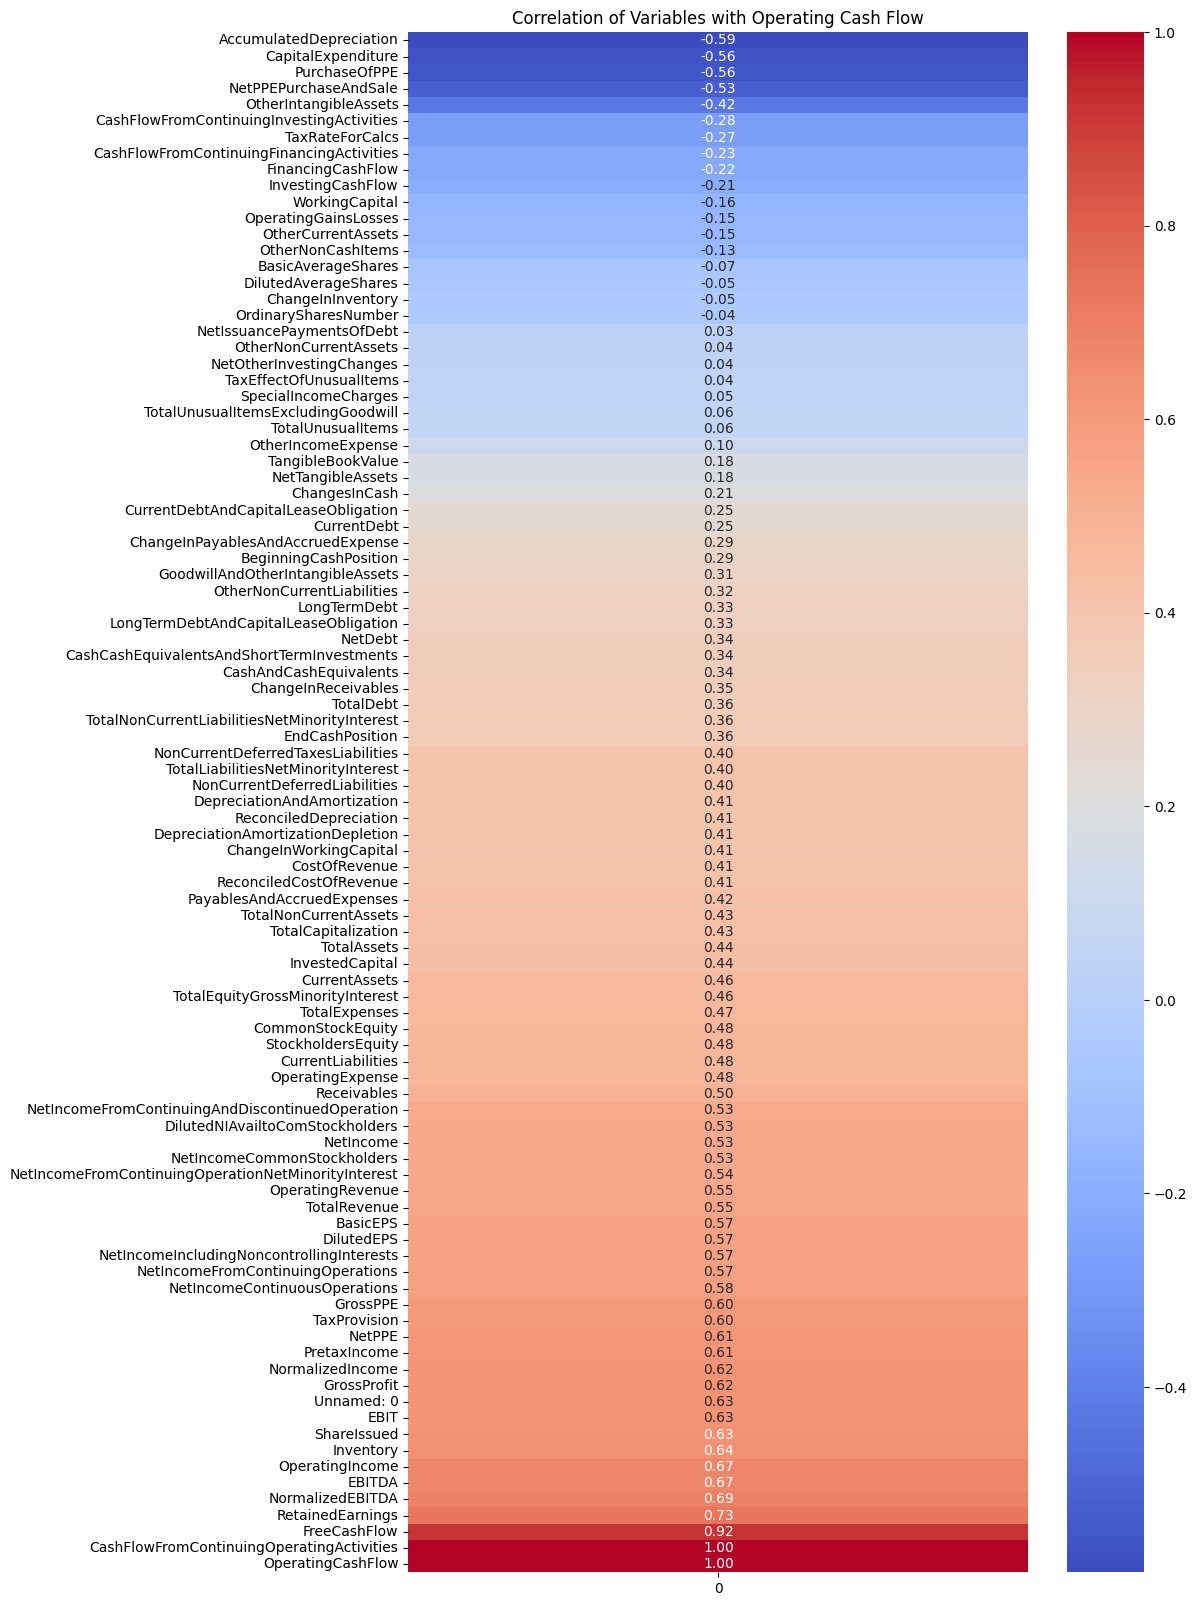

In [ ]:
# Recompute correlation of Operating Cash Flow with other variables using the correct column
correlation = data.corr()[operating_cash_flow_col].sort_values()

# Fix the heatmap plot issue by converting to a numpy array
plt.figure(figsize=(10, 20))
sns.heatmap(correlation.values[:, None], annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
            yticklabels=correlation.index)
plt.title('Correlation of Variables with Operating Cash Flow')
plt.show()

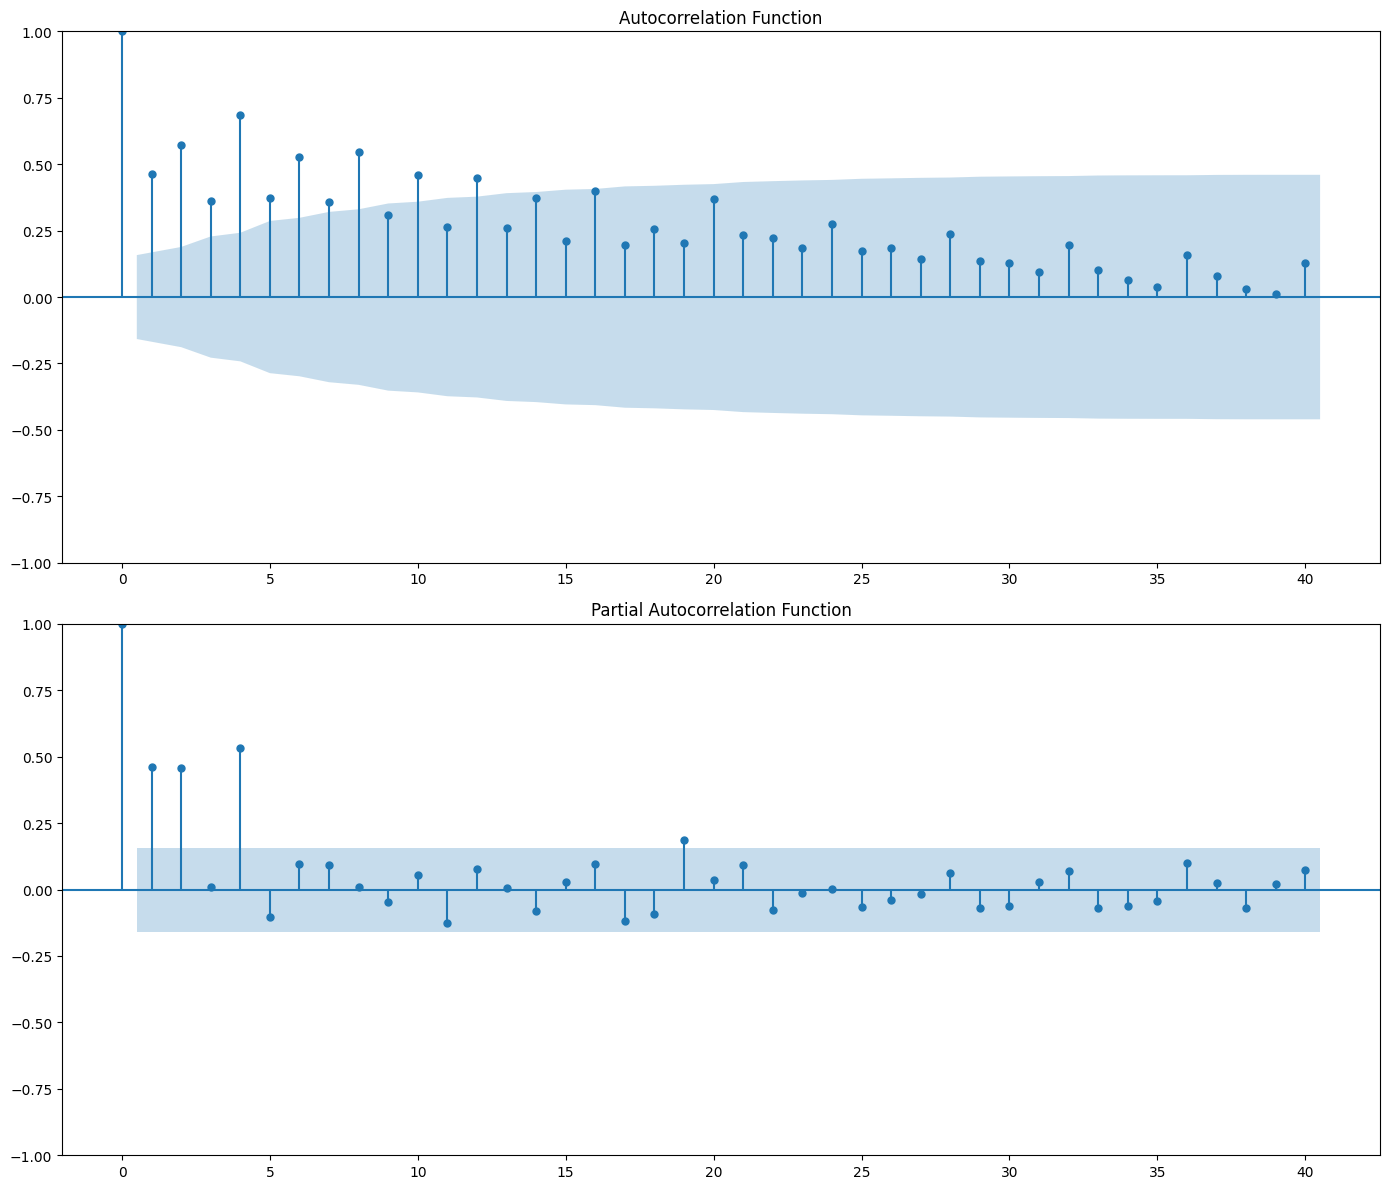

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Generate ACF and PACF plots for Operating Cash Flow
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Autocorrelation plot
plot_acf(data[operating_cash_flow_col], lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function')

# Partial Autocorrelation plot
plot_pacf(data[operating_cash_flow_col], lags=40, ax=ax2, method='ywm')
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Configure and fit the SARIMAX model on the training data
model = SARIMAX(train[operating_cash_flow_col], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# Summary of the model fit
model_summary = model_fit.summary()
model_summary


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      OperatingCashFlow   No. Observations:                  123
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2632.888
Date:                Fri, 12 Apr 2024   AIC                           5271.776
Time:                        20:30:36   BIC                           5280.188
Sample:                    09-30-1985   HQIC                          5275.193
                         - 03-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2658      0.126     -2.112      0.035      -0.513      -0.019
ma.L1         -0.7213      0.087     -8.316      0.000      -0.891      -0.551
sigma2      3.749e+17   8.41e-21   4.46e+37      0.000    3.75e+17    3.75e+17
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                10.84
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):              18.16   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.84e+54. Standard errors may be unstable.
"""

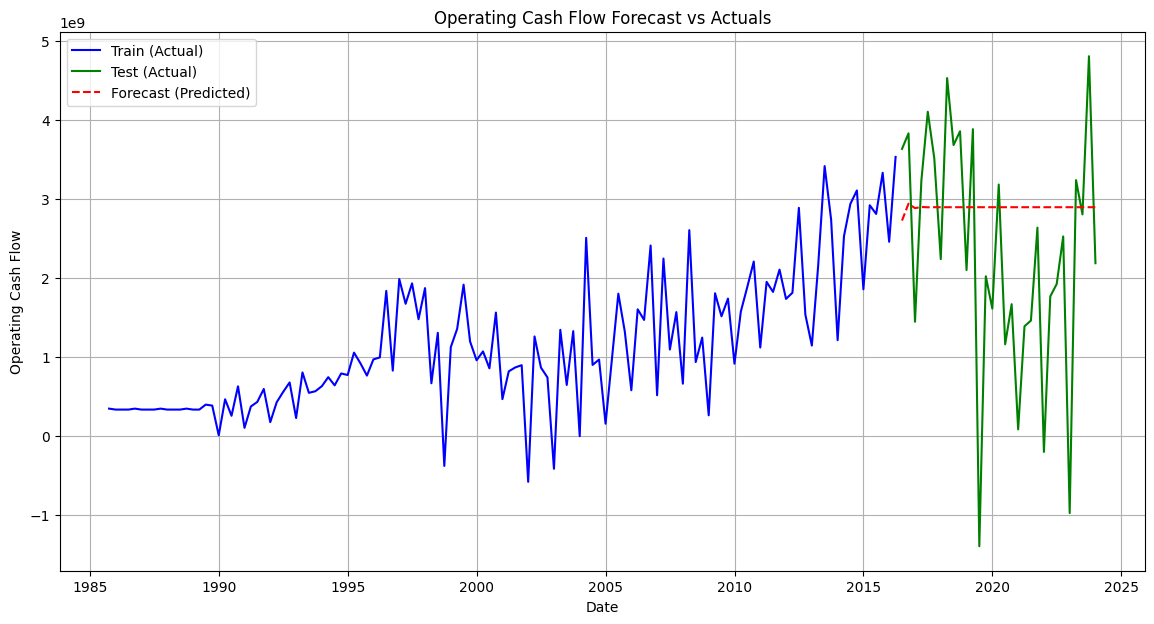

1613022250.73292

In [ ]:
from statsmodels.tools.eval_measures import rmse

# Forecast the test set
forecast = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

# Calculate RMSE
forecast_rmse = rmse(test[operating_cash_flow_col], forecast_mean)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(train.index, train[operating_cash_flow_col], label='Train (Actual)', color='blue')
plt.plot(test.index, test[operating_cash_flow_col], label='Test (Actual)', color='green')
plt.plot(test.index, forecast_mean, label='Forecast (Predicted)', color='red', linestyle='--')
plt.title('Operating Cash Flow Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Operating Cash Flow')
plt.legend()
plt.grid(True)
plt.show()

forecast_rmse

In [ ]:
# Identify top correlated variables with Operating Cash Flow, excluding itself
top_exogenous = data.corr()[operating_cash_flow_col].sort_values(ascending=False).drop(operating_cash_flow_col).head(5).index.tolist()

# Prepare exogenous variables
exog_data = data[top_exogenous]

# Split exogenous data into training and testing sets corresponding to the main train/test split
exog_train, exog_test = exog_data[:train_size], exog_data[train_size:]

# Reconfigure and fit the SARIMAX model with exogenous variables
model_with_exog = SARIMAX(train[operating_cash_flow_col], exog=exog_train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_with_exog_fit = model_with_exog.fit(disp=False)

# Summary of the new model fit
model_with_exog_summary = model_with_exog_fit.summary()
model_with_exog_summary


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      OperatingCashFlow   No. Observations:                  123
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1986.968
Date:                Fri, 12 Apr 2024   AIC                           3989.937
Time:                        20:30:39   BIC                           4012.369
Sample:                    09-30-1985   HQIC                          3999.048
                         - 03-31-2016                                         
Covariance Type:                  opg                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
CashFlowFromContinuingOperatingActivities     0.9998      0.003    290.677      0.000       0.993       1.007
FreeCashFlow                                  0.0009      0.002      0.376      0.707      -0.004       0.006
RetainedEarnings                          -2.741e-05      0.000     -0.097      0.923      -0.001       0.001
NormalizedEBITDA                             -0.0025      0.001     -1.746      0.081      -0.005       0.000
EBITDA                                        0.0024      0.003      0.892      0.372      -0.003       0.008
ar.L1                                        -0.5105      0.049    -10.354      0.000      -0.607      -0.414
ma.L1                                        -0.7757      0.092     -8.465      0.000      -0.955      -0.596
sigma2                                     1.131e+13    5.3e-15   2.13e+27      0.000    1.13e+13    1.13e+13
===================================================================================
Ljung-Box (L1) (Q):                   2.47   Jarque-Bera (JB):              4645.32
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):             394.24   Skew:                             3.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.14e+42. Standard errors may be unstable.
"""

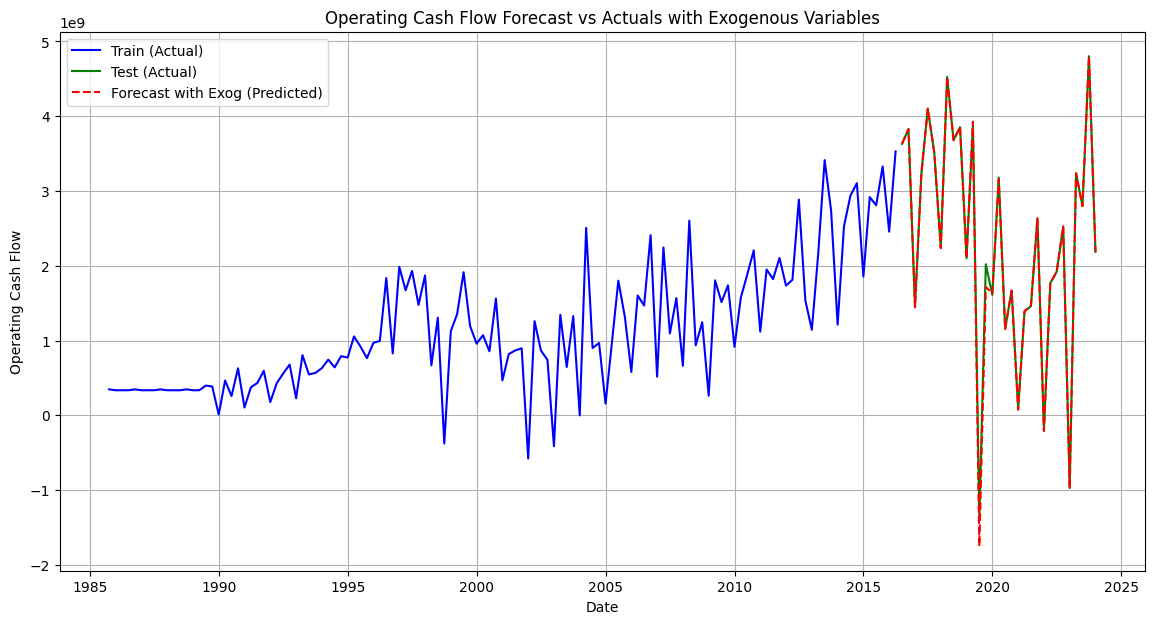

85056627.35113262

In [ ]:
# Forecast the test set with the updated model including exogenous variables
forecast_with_exog = model_with_exog_fit.get_forecast(steps=len(test), exog=exog_test)
forecast_with_exog_mean = forecast_with_exog.predicted_mean

# Calculate RMSE for the new forecast
forecast_with_exog_rmse = rmse(test[operating_cash_flow_col], forecast_with_exog_mean)

# Plot actual vs predicted values with exogenous variables included
plt.figure(figsize=(14, 7))
plt.plot(train.index, train[operating_cash_flow_col], label='Train (Actual)', color='blue')
plt.plot(test.index, test[operating_cash_flow_col], label='Test (Actual)', color='green')
plt.plot(test.index, forecast_with_exog_mean, label='Forecast with Exog (Predicted)', color='red', linestyle='--')
plt.title('Operating Cash Flow Forecast vs Actuals with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Operating Cash Flow')
plt.legend()
plt.grid(True)
plt.show()

forecast_with_exog_rmse


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test[operating_cash_flow_col], forecast_with_exog_mean)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test[operating_cash_flow_col] - forecast_with_exog_mean) / test[operating_cash_flow_col])) * 100

mae, mape


(26264448.03630244, 2.051902252729053)

In [ ]:
# Combine actual and predicted values into a DataFrame
comparison_df = pd.DataFrame({
    'Actual': test[operating_cash_flow_col],
    'Predicted': forecast_with_exog_mean.round(0).astype(int)  # Rounding predicted values to the nearest integer
})

# Print the DataFrame to see the actual and predicted values side by side in the same format
print(comparison_df)


                Actual   Predicted
2016-06-30  3630000000  3630458731
2016-09-30  3827000000  3827495583
2016-12-31  1445000000  1443862713
2017-03-31  3228000000  3228164638
2017-06-30  4100000000  4100900728
2017-09-30  3512000000  3512408459
2017-12-31  2237000000  2236161509
2018-03-31  4526000000  4526763301
2018-06-30  3679000000  3678893487
2018-09-30  3853000000  3854576012
2018-12-31  2099000000  2097698019
2019-03-31  3880000000  3926500551
2019-06-30 -1393000000 -1751356050
2019-09-30  2020000000  1715937598
2019-12-31  1611000000  1628974184
2020-03-31  3180000000  3157453274
2020-06-30  1160000000  1151003709
2020-09-30  1667000000  1668224246
2020-12-31    84000000    73994135
2021-03-31  1388000000  1392746989
2021-06-30  1460000000  1465616135
2021-09-30  2635000000  2632497548
2021-12-31  -201000000  -211551573
2022-03-31  1765000000  1764077264
2022-06-30  1922000000  1920845450
2022-09-30  2524000000  2524682343
2022-12-31  -974000000  -976687723
2023-03-31  32360000

In [ ]:
# Ensure the data has a quarterly frequency and get the last date
last_date = data.index.max()

# Forecasting Q1 2024, which means we need to forecast for dates beyond the last date
# Calculate the number of quarters between the last date and Q1 2024
# Assuming the data is quarterly and ends in 2016 as from the predicted value's date
from pandas.tseries.offsets import QuarterEnd

# Find out how many quarters to forecast to reach 2024-Q1
forecast_start_date = '2024-03-31'
forecast_period = pd.date_range(start=last_date, end=forecast_start_date, freq='Q')[1:]  # Excluding the last date itself

# Number of steps to forecast
steps_to_forecast = len(forecast_period)

# Using the last known exogenous values for forecasting (if exogenous variables are required)
# Here we simplify by not using exogenous variables due to lack of future data
model_simple = SARIMAX(data[operating_cash_flow_col], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_simple_fit = model_simple.fit(disp=False)

# Forecast the required steps to reach 2024 Q1
forecast_for_2024_Q1 = model_simple_fit.get_forecast(steps=steps_to_forecast)
predicted_cash_flow_for_2024_Q1 = forecast_for_2024_Q1.predicted_mean.iloc[-1]  # Get the last forecast which corresponds to 2024 Q1

predicted_cash_flow_for_2024_Q1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


2818890012.6162744

In [ ]:
# Ensure the model's frequency setting matches the data's frequency and covers up to 2024-Q1
# Set the forecast index manually to extend from the last data point to 2024 Q1
forecast_index = pd.date_range(start=last_date + pd.DateOffset(days=1), end=forecast_start_date, freq='Q-DEC')

# Check if the forecast index is set correctly
forecast_index


DatetimeIndex(['2024-03-31'], dtype='datetime64[ns]', freq='Q-DEC')

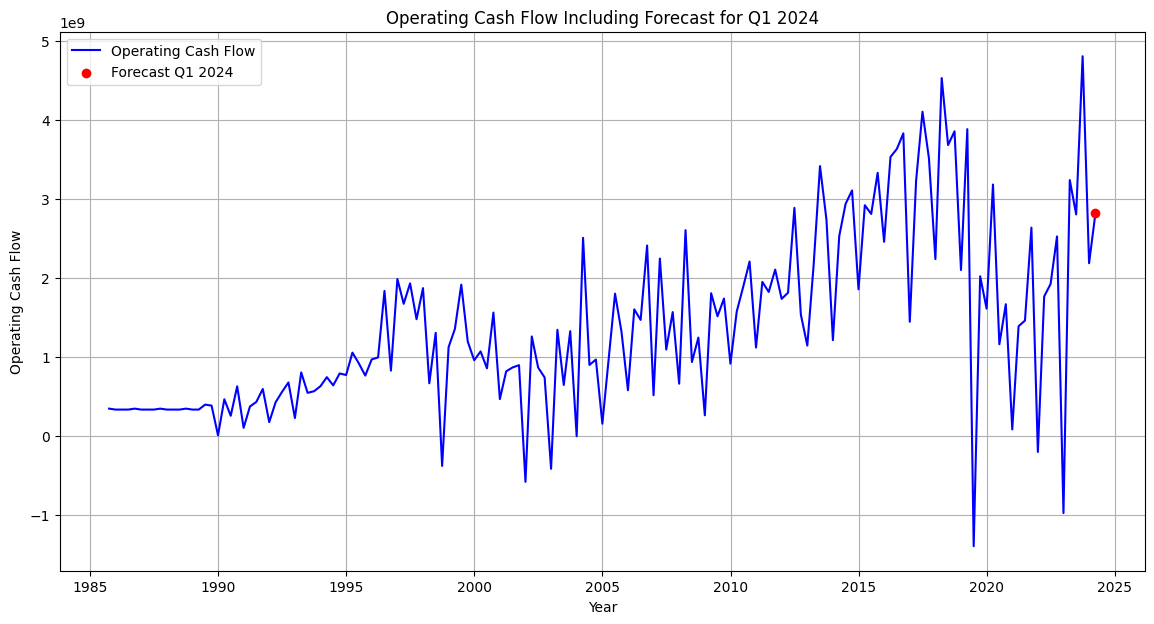

In [ ]:
import matplotlib.pyplot as plt

# Assume 'predicted_value_2024_Q1' is your forecasted value for Q1 2024
# and 'data' is your original DataFrame with Operating Cash Flow

# Append the forecasted value to the existing data
extended_data = data[operating_cash_flow_col].copy()
extended_data.loc['2024-03-31'] = predicted_cash_flow_for_2024_Q1  # Ensure this date is the exact forecast target date

# Plot the extended data
plt.figure(figsize=(14, 7))
plt.plot(extended_data.index, extended_data, label='Operating Cash Flow', color='blue')

# Highlight the 2024 forecast
plt.scatter(['2024-03-31'], [predicted_cash_flow_for_2024_Q1], color='red', label='Forecast Q1 2024', zorder=5)

# Add titles and labels
plt.title('Operating Cash Flow Including Forecast for Q1 2024')
plt.xlabel('Year')
plt.ylabel('Operating Cash Flow')
plt.legend()
plt.grid(True)
plt.show()
